## Recupération des news


In [4]:
#!pip install wordcloud
#!pip install nltk

     |████████████████████████████████| 363 kB 1.6 MB/s            
     |████████████████████████████████| 1.5 MB 1.7 MB/s            
     |████████████████████████████████| 763 kB 43.6 MB/s            


In [36]:
import requests
from bs4 import BeautifulSoup
import pandas as pd


#partie wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import urllib


# partie NLP
import nltk

nltk.download('punkt')
words = nltk.download('stopwords')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
def get_company():

    url = 'https://www.investing.com/equities'
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    soup = BeautifulSoup(r.content, 'html.parser')
    tbody = soup.findAll("td",{"class":"bold left noWrap elp plusIconTd"})
    l = []
    for p in tbody:
        l.append(p.find("a")['href'].split('/')[2])
    return l

In [7]:
liste_entreprise = get_company()
liste_entreprise

['boeing-co',
 'chevron',
 'caterpillar',
 'intel-corp',
 'microsoft-corp',
 'disney',
 'dow-chemical',
 'cisco-sys-inc',
 'goldman-sachs-group',
 'jp-morgan-chase',
 'coca-cola-co',
 'mcdonalds',
 'merck---co',
 '3m-co',
 'apple-computer-inc',
 'amgen-inc',
 'wal-mart-stores',
 'home-depot',
 'ibm',
 'verizon-communications',
 'the-travelers-co',
 'johnson-johnson',
 'american-express',
 'honeywell-intl',
 'salesforce-com',
 'visa-inc',
 'walgreen-co',
 'united-health-group',
 'nike',
 'procter-gamble']

In [8]:
def get_news(company,nb_page=1):
    url = 'https://www.investing.com/equities/'+company+'-news/'+str(nb_page)
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    soup = BeautifulSoup(r.content, 'html.parser')
    article_body = soup.findAll("a",{"class":"title"})
    #print(article_body)
    l=[]
    for p in article_body:
        l.append(p.get("title"))
    return l[6:]

In [9]:
print(get_news("tesla-motors",3))

['4 Most Surprising Crypto-related Tweets of 2021', 'Shiba Inu Price Prediction For 2022', 'Pre-Market Movers: Godaddy Pops, Didi, Airlines, and BridgeBio Pharma Sell Off', 'Cheems Inu – The New Dog In Town', '3 Most Influential Top Crypto Names of 2021', 'The biggest letdowns in crypto and blockchain in 2021 ', 'Asset bubbles? Champagne outfizzes Big Tech and bitcoin in 2021', 'Daimler, BYD to restructure China EV venture Denza', 'Retailers to drive crypto payments adoption: Survey', 'Top 5 bullish Bitcoin stories of 2021', 'Should you use a trading bot? The good, the bad, and the ugly of algorithmic trading.', 'Alvexo - Non-Farm Payroll Report (NFP): Live Trading Event']


In [10]:
def get_tilte_dictionary(company_list, number_page=1):
    dicto = {}
    for company in company_list :
        l = []
        for page in range(1,number_page+1):
            l = l + get_news(company, page)
        dicto[str(company)] = ' '.join(l).lower()
    
    return dicto


## Word cloud version simple

Peut-être essayer de faire un truc qui cherche le masque automatiquement à partir du nom de l'entreprise si on le sent

In [11]:
data = get_tilte_dictionary(liste_entreprise[:2],1)

In [12]:
print(data['boeing-co'])

s&p 500 ends lower after four-day rally to record high u.s. stocks mixed at close of trade; dow jones industrial average up 0.26% s&p 500 snaps record run after briefly topping 4,800 s&p 500 eases from record as tech stumble offsets rebound in travel stocks stocks making the biggest moves midday: coinbase, boeing, carnival and more s&p 500 sets record, u.s. markets higher in muted 'rebalancing' trade boeing and disney are biggest winners as dow puts distance between it and 36,000 boeing 737 max cleared to resume flying in indonesia, scene of first crash indonesia allows boeing's 737 max to fly again after deadly crash s&p 500 closes at all-time highs as tech and energy drive the santa rally should you use a trading bot? the good, the bad, and the ugly of algorithmic trading. alvexo - non-farm payroll report (nfp): live trading event


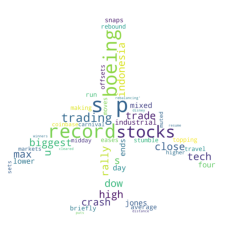

In [13]:
mask = np.array(Image.open(requests.get('https://www.freeiconspng.com/uploads/airplane-icon-image-gallery-1.png', stream=True).raw))

wordcloud = WordCloud(background_color = 'white', max_words = 50, mask  = mask).generate(data[liste_entreprise[0]])
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

# NLP

## Tokenization

In [14]:
words = nltk.word_tokenize(data[liste_entreprise[0]])
#print(words)

## suppression de la ponctuation


In [15]:
words = [word for word in words if word.isalpha()] #cela retire le mot u.s,  on peux supposer que cela n'a pas beaucoup d'impact puisque nous travaillons uniquement sur des données des u.s
#print(words)

## retirer les stop word

In [16]:
stop_words = set(stopwords.words('english'))
keep_words = ['up', 'down', 'under','no'] #modifier cette liste ????
stop_words = [word for word in stop_words if word not in keep_words]
words = [ word for word in words if not word in stop_words]
#print(words)
#print(stopwords)

## stemming

In [17]:
stemmer = SnowballStemmer(language = 'english')
stemmed = [stemmer.stem(word) for word in words]
#print(stemmed)

## Fonction qui transforme les données d'un seul coup:

In [18]:
def clean_text(text):
    words = nltk.word_tokenize(text)
    
    words = [word for word in words if word.isalpha()]
    
    stop_words = set(stopwords.words('english'))
    keep_words = ['up', 'down', 'under','no'] #modifier cette liste ????
    stop_words = [word for word in stop_words if word not in keep_words]
    words = [ word for word in words if not word in stop_words]
    
    stemmer = SnowballStemmer(language = 'english')
    stemmed = [stemmer.stem(word) for word in words]
    
    return(' '.join(stemmed))

In [19]:
def return_sentiment(company_data):
    text = clean_text(company_data)
    sid = SentimentIntensityAnalyzer()
    l = sid.polarity_scores(clean_text(company_data))
    return(l['pos']*1.5 + l['neu'] - l['neg']*1.5) #fonction faites à la main,à discuter

In [20]:
def build_data_sentiment(company_list, page=1):
    data = get_tilte_dictionary(company_list, page)
    df = pd.DataFrame(columns = ['company','score'])
    for company in company_list : 
        df = df.append({'company': str(company), 'score':return_sentiment(data[company])},ignore_index=True)
    return df

In [21]:
df = build_data_sentiment(liste_entreprise[:5],3) #surment un peu long pour le dataframe complet !!!

In [22]:
df = df.set_index('company')
ordered_df = df['score'].sort_values(ascending = False)

In [23]:
kept_company = ordered_df[:8]
print(kept_company)

company
caterpillar    0.8875
intel-corp     0.8530
Name: score, dtype: float64


In [66]:
def get_tickers(company):
    url = 'https://www.investing.com/equities/'+company
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    soup = BeautifulSoup(r.content, 'html.parser')
    article_body = soup.findAll("h1",{"class":"text-2xl font-semibold instrument-header_title__GTWDv mobile:mb-2"})
    #print(article_body)
    ticker = str(re.search(r'\((.*?)\)',str(article_body)).group(0) )
    ticker = re.search(r'[a-zA-Z]+',ticker ).group(0) 
    return ticker

In [70]:
def get_ticker_list(kept_company):
    l=[]
    for i in range(len(kept_company)):
        l.append(get_tickers(kept_company.index[i]))
    return l

In [71]:
get_ticker_list(kept_company)

['CAT', 'INTC']